In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from livelossplot import PlotLosses
from tqdm import tnrange, tqdm_notebook
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout, LeakyReLU, Lambda
from keras.layers.wrappers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from IPython import display as dp
import os
import pickle

sns.set_style('whitegrid')
sns.despine()

dp.set_matplotlib_formats('retina')

%matplotlib inline

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A stateful LSTM, reads `horizon` time steps, predicts next one for each, outputs all answers.

In [2]:
class DataLoader():
    """
    Batches generator.
    
    Takes a directory `path`, sequentially reads `batch_size` files, then
        sequentially reads `horizon` timestamps from each file.
        
    Args:
        path (str): Path to collection.
        batch_size (int): Number of documents per batch.
        horizon (int): Number of timestamps per batch.
        dimension (int): Series vector length.
    """
    def __init__(self, path, batch_size, horizon, dimension):
        self._batch_size = batch_size
        self._horizon = horizon
        self._dimension = dimension
        self._collection = [os.path.join(path, x) for x in os.listdir(path) if x != '.DS_Store']
        self._collection_size = len(self._collection)
        self._num_batches = self._collection_size // self._batch_size + 1
        self._cursor_collection = 0
        self._cursor_file = 0
        with open('sc.pickle', 'rb') as f:
            self._sc = pickle.load(f)
        self._read_next_files()
        self._file_size = 125000
        self._last_batch = False
        
    def _read_next_files(self):
        """
        Reads the collection by chunks to save memory.
        """
        files_to_read = self._collection[self._cursor_collection : self._cursor_collection + self._batch_size]
        self._cursor_collection += self._batch_size
        if self._cursor_collection > self._collection_size:
            diff = self._cursor_collection % self._collection_size
            self._cursor_collection = diff
            files_to_read.extend(self._collection[0 : diff])
        self._files = [self._sc.transform(pd.read_csv(fpath).drop(['t'], axis=1).values) for fpath in files_to_read]
        
    def _read_from_files(self):
        """
        Reads one timestamp for multiple series.
        
        Returns:
            batch (numpy array): Array of shape (batch_size, 1, dimension).
            reset (bool): Whether states should be reset.
        """
        batch = np.zeros((self._batch_size, self._dimension))
        for i, doc in enumerate(self._files):
            batch[i] = doc[self._cursor_file]
        self._cursor_file += 1
        if self._cursor_file == self._file_size:
            self._cursor_file = self._cursor_file % self._file_size
            self._read_next_files()
            return batch, True
        else:
            return batch, False
        
    def next(self):
        """
        Reads multiple timestamps for multiple series, i.e. complete batch.
        """
        batch = np.zeros((self._batch_size, self._horizon, self._dimension))
        for i in range(self._horizon):
            b, reset = self._read_from_files()
            batch[:, i, :] = b
            if reset:
                self._last_batch = True
                return batch, True
        self._last_batch = False
        return batch, False

In [3]:
class DataLoaderOverlap():
    """
    Batches generator.
    
    Takes a directory `path`, sequentially reads `batch_size` files, then
        sequentially reads `horizon` timestamps from each file.
        
    Args:
        path (str): Path to collection.
        batch_size (int): Number of documents per batch.
        horizon (int): Number of timestamps per batch.
        dimension (int): Series vector length.
    """
    def __init__(self, path, batch_size, horizon, dimension):
        self._batch_size = batch_size
        self._horizon = horizon
        self._dimension = dimension
        self._collection = [os.path.join(path, x) for x in os.listdir(path) if x != '.DS_Store']
        self._collection_size = len(self._collection)
        self._num_batches = self._collection_size // self._batch_size + 1
        self._cursor_collection = 0
        self._cursor_file = 0
        with open('sc.pickle', 'rb') as f:
            self._sc = pickle.load(f)
        self._read_next_files()
        self._file_size = 125023
        self._last_batch = self._read_from_files()
        
    def _read_next_files(self):
        """
        Reads the collection by chunks to save memory.
        """
        files_to_read = self._collection[self._cursor_collection : self._cursor_collection + self._batch_size]
        self._cursor_collection += self._batch_size
        if self._cursor_collection > self._collection_size:
            diff = self._cursor_collection % self._collection_size
            self._cursor_collection = diff
            files_to_read.extend(self._collection[0 : diff])
        self._files = [self._sc.transform(pd.read_csv(fpath).drop(['t'], axis=1).values) for fpath in files_to_read]
        
    def _read_from_files(self):
        """
        Reads one timestamp for multiple series.
        
        Returns:
            batch (numpy array): Array of shape (batch_size, 1, dimension).
            reset (bool): Whether states should be reset.
        """
        batch = np.zeros((self._batch_size, self._dimension))
        for i, doc in enumerate(self._files):
            batch[i] = doc[self._cursor_file]
        self._cursor_file += 1
        if self._cursor_file == self._file_size:
            self._cursor_file = self._cursor_file % self._file_size
            self._read_next_files()
            return batch, True
        else:
            return batch, False
        
    def next(self):
        """
        Reads multiple timestamps for multiple series, i.e. complete batch.
        """
        batch = np.zeros((self._batch_size, self._horizon + 1, self._dimension))
        if self._last_batch[1]:
             self._last_batch = self._read_from_files()
        batch[:, 0, :] = self._last_batch[0]
        for i in range(1, self._horizon + 1):
            b, reset = self._read_from_files()
            batch[:, i, :] = b
            if reset:
                self._last_batch = self._last_batch[0], True
                return batch, True
        self._last_batch = batch[:, -1, :], False
        return batch, False

In [4]:
epochs = 10000
batch_size = 50
num_hidden = 100
num_vars = 2
horizon = 50
dropout = 0.1

In [5]:
encoder_inputs = Input(batch_shape=(batch_size, None, num_vars))
encoder = LSTM(num_hidden, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(batch_shape=(batch_size, 1, num_vars))
decoder_lstm = LSTM(num_hidden, return_sequences=True, return_state=True)
decoder_dense = TimeDistributed(Dense(num_vars))

all_outputs = []
inputs = decoder_inputs
states = encoder_states
for _ in range(horizon):
    outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
    outputs = decoder_dense(outputs)
    all_outputs.append(outputs)
    inputs = outputs
    states = [state_h, state_c]

decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# lstm + Dense
inputs = Input(batch_shape=(batch_size, horizon, num_vars))
logits = LSTM(num_hidden, stateful=True, return_sequences=True, kernel_regularizer='l2',
              recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2')(inputs)
logits = BatchNormalization()(logits)
logits = LeakyReLU()(logits)
outputs = TimeDistributed(Dense(50, kernel_regularizer='l2', bias_regularizer='l2'))(logits)
outputs = LeakyReLU()(outputs)
outputs = TimeDistributed(Dense(num_vars, kernel_regularizer='l2', bias_regularizer='l2'))(outputs)
model = Model(inputs, outputs)

In [6]:
def nrmse(y_true, y_pred):
    return K.mean(K.sqrt(K.mean(K.sum((y_true - y_pred) ** 2, axis=2), axis=1)) \
                  / K.sqrt(K.mean(K.sum(y_true ** 2, axis=2), axis=1)))

In [7]:
model.compile(optimizer='adam', loss='mse', metrics=[nrmse])

In [8]:
dl = DataLoaderOverlap('data', batch_size, horizon, num_vars * 2)

In [54]:
rolling = []
chunk = 0
for epoch in tnrange(int(4e5)):
    batch, reset = dl.next()
    hist_mse, hist_nrmse = model.train_on_batch([batch[:, :, :2],
                                                 batch[:, 0, 2:].reshape(batch_size, 1, num_vars)],
                                                batch[:, 1:, 2:])
    rolling.append(hist_nrmse)
    if epoch > 0 and epoch % 2500 == 0:
        print('Chunk', chunk, 'rolling mean RMSE', np.mean(rolling).round(3), 
              'max', np.max(rolling).round(3), 'min', np.min(rolling).round(3))
        rolling = []
        chunk = (chunk + 1) % 4

HBox(children=(IntProgress(value=0, max=400000), HTML(value='')))

Chunk 0 rolling mean RMSE 0.02 max 0.818 min 0.002
Chunk 1 rolling mean RMSE 0.018 max 0.888 min 0.002
Chunk 2 rolling mean RMSE 0.02 max 0.914 min 0.002
Chunk 3 rolling mean RMSE 0.018 max 0.964 min 0.002
Chunk 0 rolling mean RMSE 0.017 max 0.951 min 0.001
Chunk 1 rolling mean RMSE 0.02 max 0.89 min 0.002
Chunk 2 rolling mean RMSE 0.019 max 1.243 min 0.002
Chunk 3 rolling mean RMSE 0.017 max 0.939 min 0.002
Chunk 0 rolling mean RMSE 0.017 max 1.145 min 0.001
Chunk 1 rolling mean RMSE 0.015 max 1.058 min 0.001
Chunk 2 rolling mean RMSE 0.017 max 0.983 min 0.001
Chunk 3 rolling mean RMSE 0.015 max 0.95 min 0.001
Chunk 0 rolling mean RMSE 0.015 max 1.005 min 0.001
Chunk 1 rolling mean RMSE 0.015 max 0.98 min 0.001
Chunk 2 rolling mean RMSE 0.014 max 1.064 min 0.002
Chunk 3 rolling mean RMSE 0.015 max 1.017 min 0.002
Chunk 0 rolling mean RMSE 0.014 max 0.978 min 0.002
Chunk 1 rolling mean RMSE 0.012 max 0.93 min 0.001
Chunk 2 rolling mean RMSE 0.014 max 0.932 min 0.001
Chunk 3 rolling mea

KeyboardInterrupt: 

In [10]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(batch_shape=(batch_size, num_hidden))
decoder_state_input_c = Input(batch_shape=(batch_size, num_hidden))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                 initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [ ]:
rolling = []
chunk = 0
for epoch in tnrange(int(4e5)):
    batch, reset = dl.next()
    hist_mse, hist_nrmse = model.train_on_batch(batch[:, :, :2], batch[:, :, 2:])
    rolling.append(hist_nrmse)
    if epoch > 0 and epoch % 2500 == 0:
        print('Collection %d/4' % chunk, 'rolling mean RMSE', np.mean(rolling).round(3), 
              'max', np.max(rolling).round(3), 'min', np.min(rolling).round(3))
        rolling = []
        chunk = (chunk + 1) % 4

In [90]:
vals = pd.read_csv('data_test/data_1811.csv').drop(['t'], axis=1).values

In [91]:
with open('sc.pickle', 'rb') as f:
    sc = pickle.load(f)

In [92]:
model.reset_states()

In [93]:
vals = sc.transform(vals)

In [94]:
inputs = vals[:, :2]
outputs = vals[:, 2:]

In [95]:
predicted = list()
for i in tnrange(horizon, len(vals) // horizon * horizon + 1, horizon):
    input_seq = np.zeros((batch_size, horizon, num_vars))
    input_seq[0] = inputs[i-horizon:i]
    states_value = encoder_model.predict_on_batch(input_seq)
    
    target_seq = np.zeros((batch_size, 1, num_vars))
    if i > horizon:
        target_seq[0] = predicted[-1]
    else:
        target_seq[0] = inputs[-1]
    
    for _ in range(50):
        output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
        predicted.append(output_tokens[0])
        target_seq[0] = output_tokens[0]
        states_value = [h, c]

HBox(children=(IntProgress(value=0, max=3001), HTML(value='')))

In [96]:
predicted = np.concatenate(predicted)

In [97]:
outputs = outputs[:predicted.shape[0]]

In [98]:
# var_names = ['$V$', '$\\varphi$', '$P$', '$Q$']
var_names = ['$P$', '$Q$']

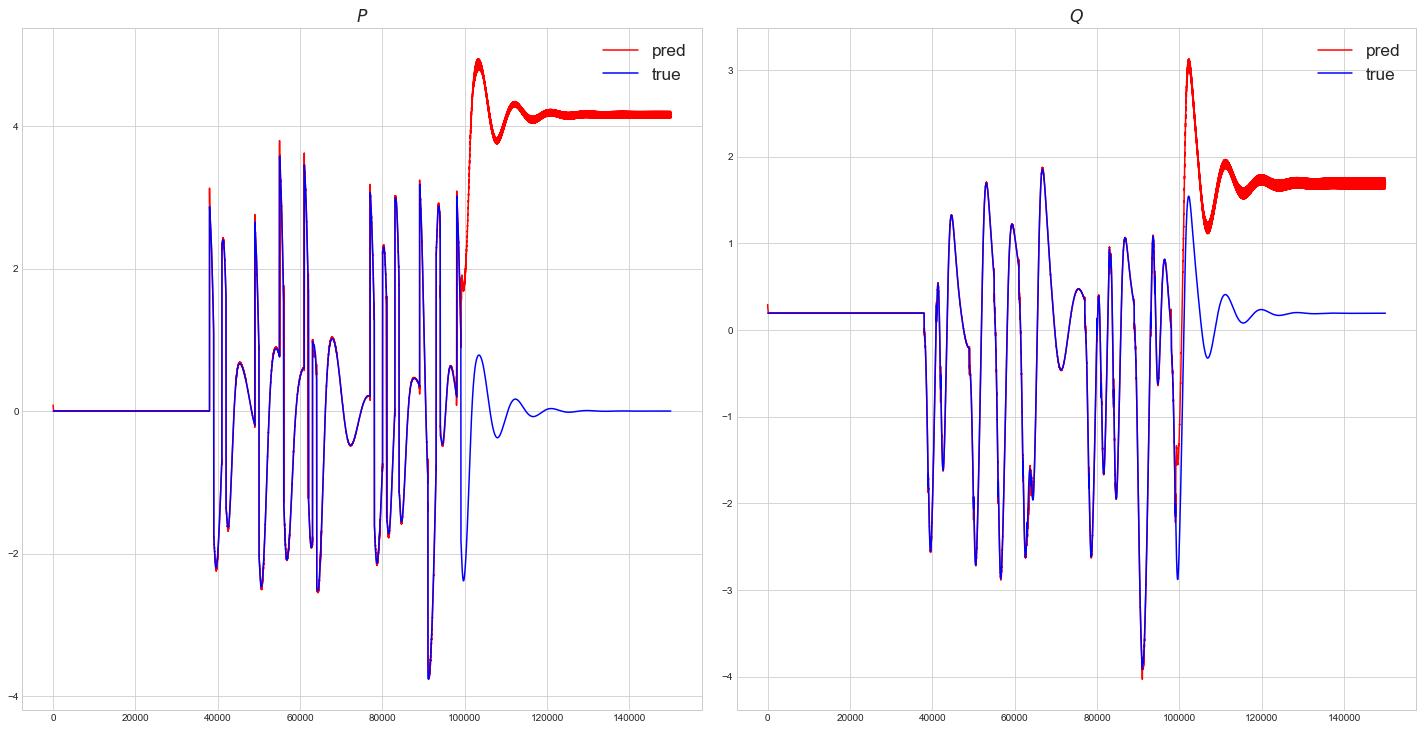

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(predicted[:, i], c='r', label='pred')
    ax.plot(outputs[:, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(predicted[:, i], c='r', label='pred')
    ax.plot(outputs[:, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [55]:
model.save('encoder-decoder-no-teacher-forcing.h5')

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(50, 100) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(50, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_2:0' shape=(50, 100) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_3:0' shape=(50, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
/Users/nickstulov/.virtualenvs/venv3/l

In [81]:
files_valid = os.listdir('data_val')
n_files = len(files_valid)
errs = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_val/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values[:150_000] for fname in fnames]
    true = [val[:, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for j in range(horizon, len(vals[0]) // horizon * horizon + 1, horizon):
        batch = np.zeros((batch_size, horizon, num_vars))
        for k in range(batch_size):
            batch[k] = inputs[k][j-horizon:j]
        states_value = encoder_model.predict_on_batch(batch)

        target_seq = np.zeros((batch_size, 1, num_vars))
        for k in range(batch_size):
            if j > horizon:
                target_seq[k] = predicted[k][j-horizon-1]
            else:
                target_seq[k] = inputs[k][-1]

        for _ in range(50):
            output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
            for k in range(batch_size):
                predicted[k][j-horizon:j] = output_tokens[k]
                target_seq[k] = output_tokens[k]
            states_value = [h, c]
            
    predicted = sc.inverse_transform(np.concatenate([inputs, predicted], axis=2))[:, :, 2:]
    
    err = [np.sqrt(np.mean(np.sum((t - p) ** 2, axis=1))) / np.sqrt(np.mean(np.sum(t ** 2, axis=1))) \
           for t, p in zip(true, predicted)]
    errs.extend(err)

HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

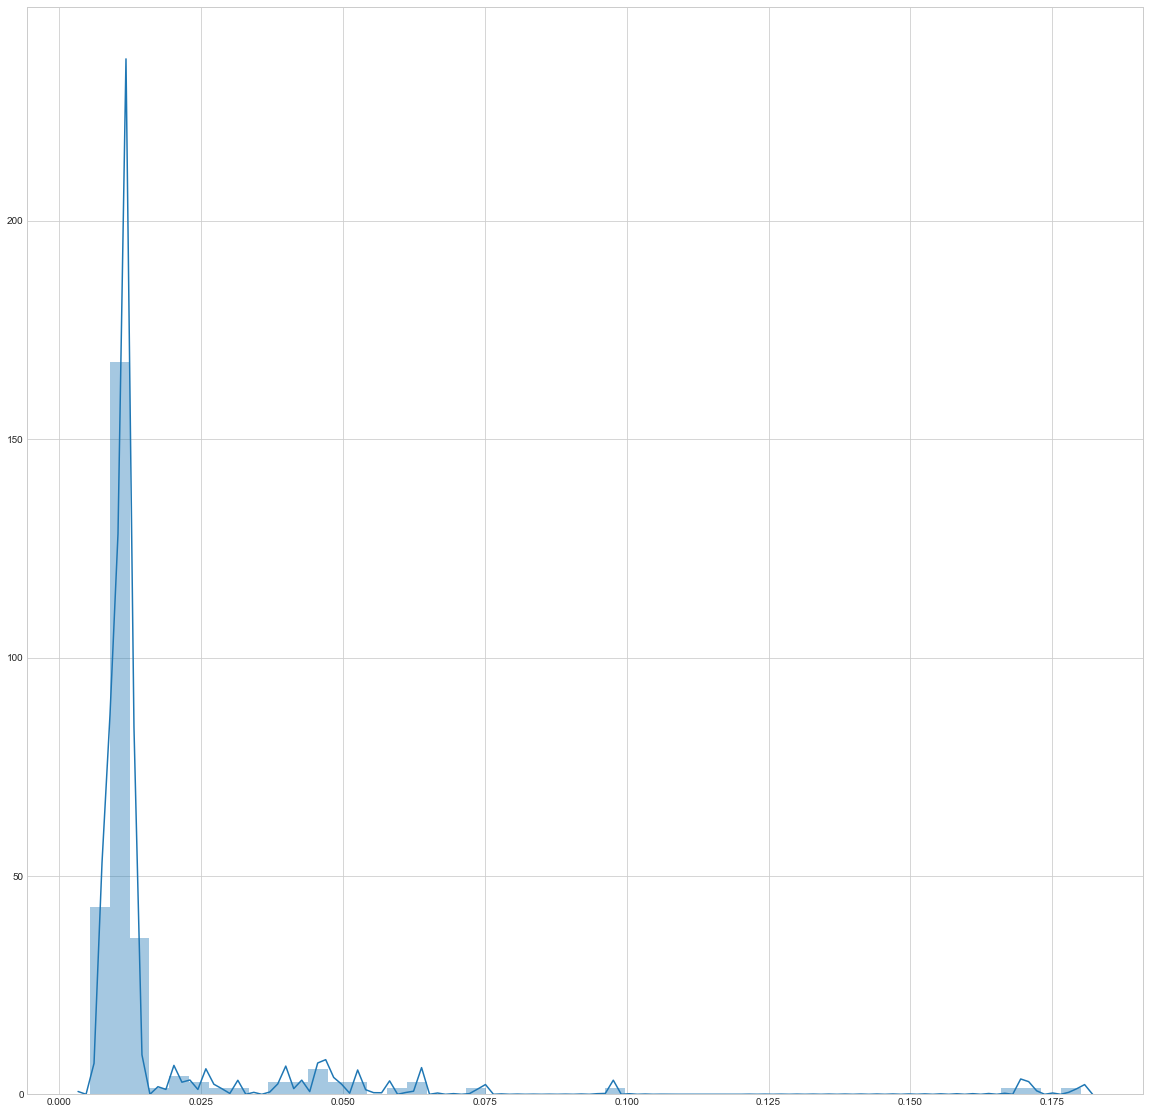

In [82]:
plt.figure(figsize=(20,20))
sns.distplot(errs)

In [83]:
print(len(np.where(np.array(errs) <= 0.05)[0]) / len(errs) * 100,
      np.percentile(errs, 95), np.mean(errs), np.median(errs))

95.0 0.04941602828705877 0.017448976087435564 0.011622306163997967


In [84]:
files_valid = os.listdir('data_test')
files_valid.pop(files_valid.index('.DS_Store'))
n_files = len(files_valid)
errs = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_test/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values[:150_000] for fname in fnames]
    true = [val[:, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for j in range(horizon, len(vals[0]) // horizon * horizon + 1, horizon):
        batch = np.zeros((batch_size, horizon, num_vars))
        for k in range(batch_size):
            batch[k] = inputs[k][j-horizon:j]
        states_value = encoder_model.predict_on_batch(batch)

        target_seq = np.zeros((batch_size, 1, num_vars))
        for k in range(batch_size):
            if j > horizon:
                target_seq[k] = predicted[k][j-horizon-1]
            else:
                target_seq[k] = inputs[k][-1]

        for _ in range(50):
            output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
            for k in range(batch_size):
                predicted[k][j-horizon:j] = output_tokens[k]
                target_seq[k] = output_tokens[k]
            states_value = [h, c]
            
    predicted = sc.inverse_transform(np.concatenate([inputs, predicted], axis=2))[:, :, 2:]
    
    err = [np.sqrt(np.mean(np.sum((t - p) ** 2, axis=1))) / np.sqrt(np.mean(np.sum(t ** 2, axis=1))) \
           for t, p in zip(true, predicted)]
    errs.extend(err)

HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

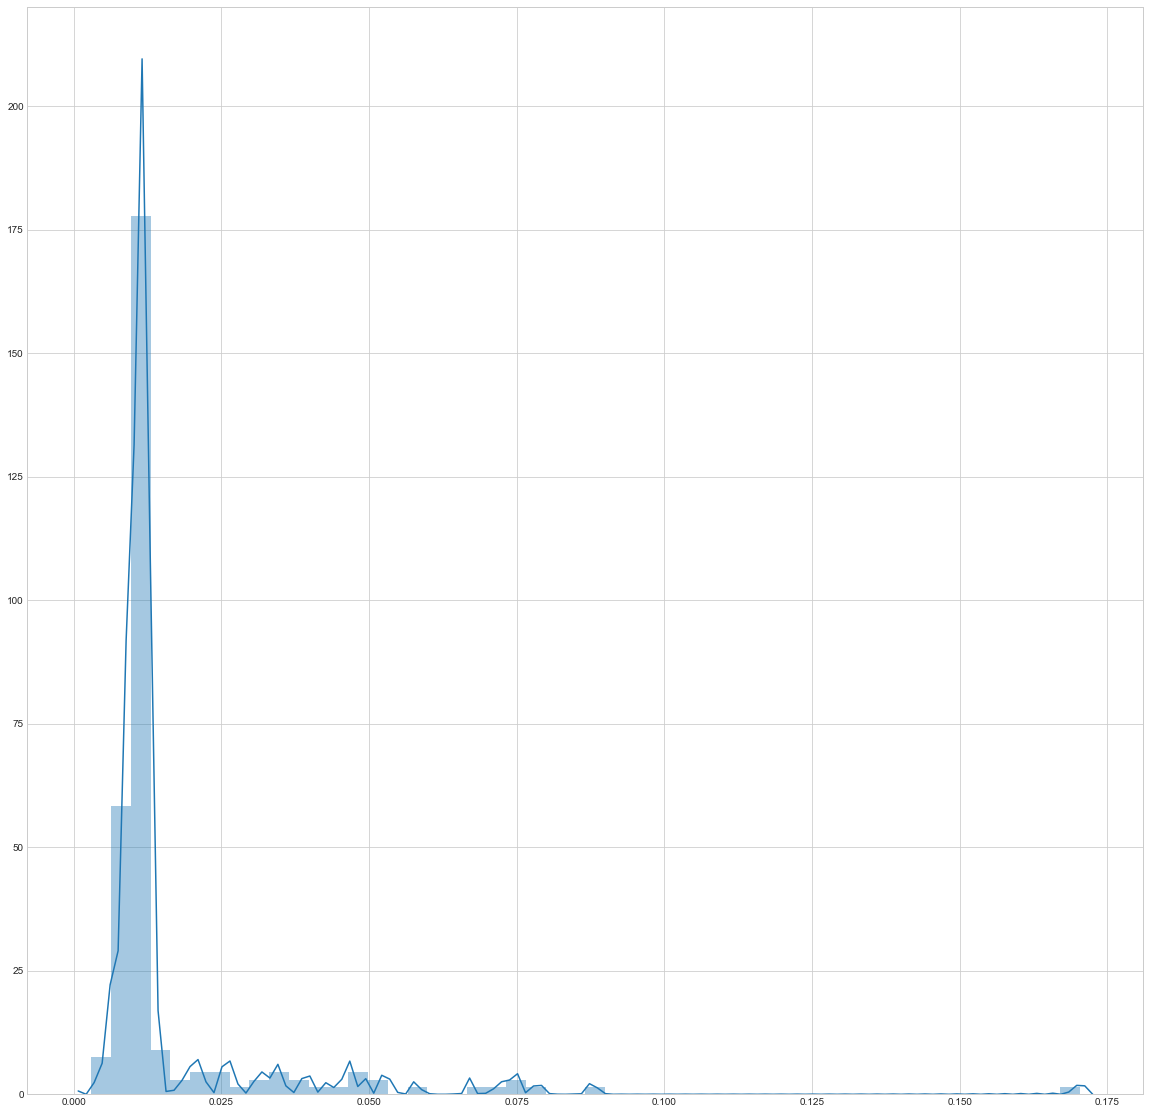

In [85]:
plt.figure(figsize=(20,20))
sns.distplot(errs)

In [86]:
print(len(np.where(np.array(errs) <= 0.05)[0]) / len(errs) * 100,
      np.percentile(errs, 95), np.mean(errs), np.median(errs))

95.0 0.049440063607796035 0.016392894655728355 0.011581448869610302


In [88]:
np.argmax(errs)

170

In [89]:
files_valid[170]

'data_1811.csv'

In [100]:
errs[-3]

0.009594611760224454

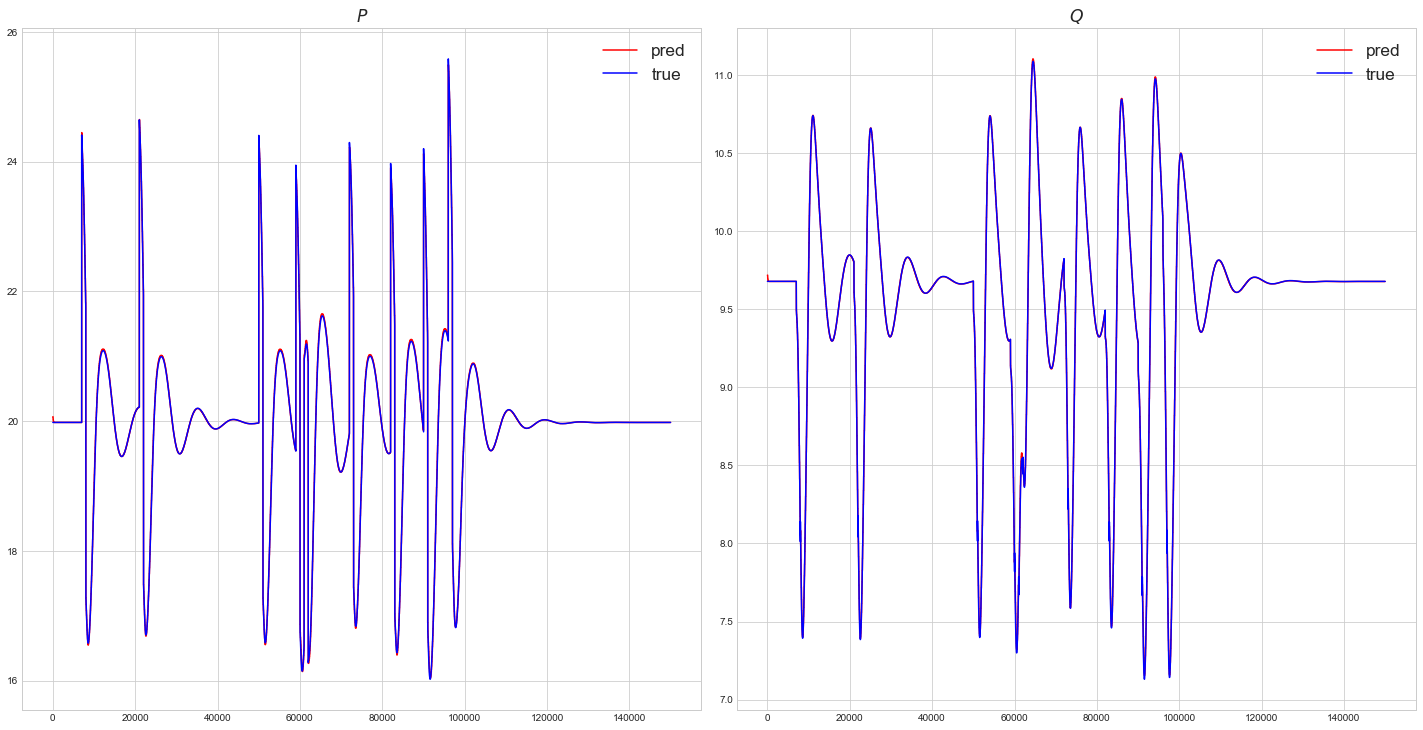

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(predicted[-3, :, i], c='r', label='pred')
    ax.plot(true[-3][:, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
files_valid = os.listdir('data_val')
n_files = len(files_valid)
errs_p = list()
errs_q = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_val/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:150_000, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for k in range(horizon, 150_000, horizon):
        batch = np.zeros((batch_size, horizon, 2))
        for j in range(batch_size):
            batch[j] = inputs[j][k-horizon:k]
        preds = model.predict_on_batch(batch)
        for j in range(batch_size):
            predicted[j][k-horizon:k] = sc.inverse_transform(np.hstack([np.zeros((horizon, 2)), preds[j]]))[:, 2:]
    err_p = [np.sqrt(np.mean((t[:, 0] - p[:, 0]) ** 2)) / np.sqrt(np.mean(t[:, 0] ** 2)) \
             for t, p in zip(true, predicted)]
    err_q = [np.sqrt(np.mean((t[:, 1] - p[:, 1]) ** 2)) / np.sqrt(np.mean(t[:, 1] ** 2)) \
             for t, p in zip(true, predicted)]
    errs_p.extend(err_p)
    errs_q.extend(err_q)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_p)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_q)

In [ ]:
print(len(np.where(np.array(errs_p) <= 0.05)[0]) / len(errs_p) * 100,
      np.percentile(errs_p, 95), np.mean(errs_p), np.median(errs_p))

In [ ]:
print(len(np.where(np.array(errs_q) <= 0.05)[0]) / len(errs_q) * 100,
      np.percentile(errs_q, 95), np.mean(errs_q), np.median(errs_q))

In [ ]:
files_valid = os.listdir('data_test')
files_valid.pop(files_valid.index('.DS_Store'))
n_files = len(files_valid)
errs_test_p = list()
errs_test_q = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_test/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:150_000, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for k in range(horizon, 150_000, horizon):
        batch = np.zeros((batch_size, horizon, 2))
        for j in range(batch_size):
            batch[j] = inputs[j][k-horizon:k]
        preds = model.predict_on_batch(batch)
        for j in range(batch_size):
            predicted[j][k-horizon:k] = sc.inverse_transform(np.hstack([np.zeros((horizon, 2)), preds[j]]))[:, 2:]
    err_p = [np.sqrt(np.mean((t[:, 0] - p[:, 0]) ** 2)) / np.sqrt(np.mean(t[:, 0] ** 2)) \
             for t, p in zip(true, predicted)]
    err_q = [np.sqrt(np.mean((t[:, 1] - p[:, 1]) ** 2)) / np.sqrt(np.mean(t[:, 1] ** 2)) \
             for t, p in zip(true, predicted)]
    errs_test_p.extend(err_p)
    errs_test_q.extend(err_q)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_test_p)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_test_q)

In [ ]:
print(len(np.where(np.array(errs_test_p) <= 0.05)[0]) / len(errs_test_p) * 100,
      np.percentile(errs_test_p, 95), np.mean(errs_test_p), np.median(errs_test_p))

In [ ]:
print(len(np.where(np.array(errs_test_q) <= 0.05)[0]) / len(errs_test_q) * 100,
      np.percentile(errs_test_q, 95), np.mean(errs_test_q), np.median(errs_test_q))